# MADE

/var/folders/sx/y6c6vjtn04719m5bcb52hk3r0000gn/T/ipykernel_85025/4080533808.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(seeds))


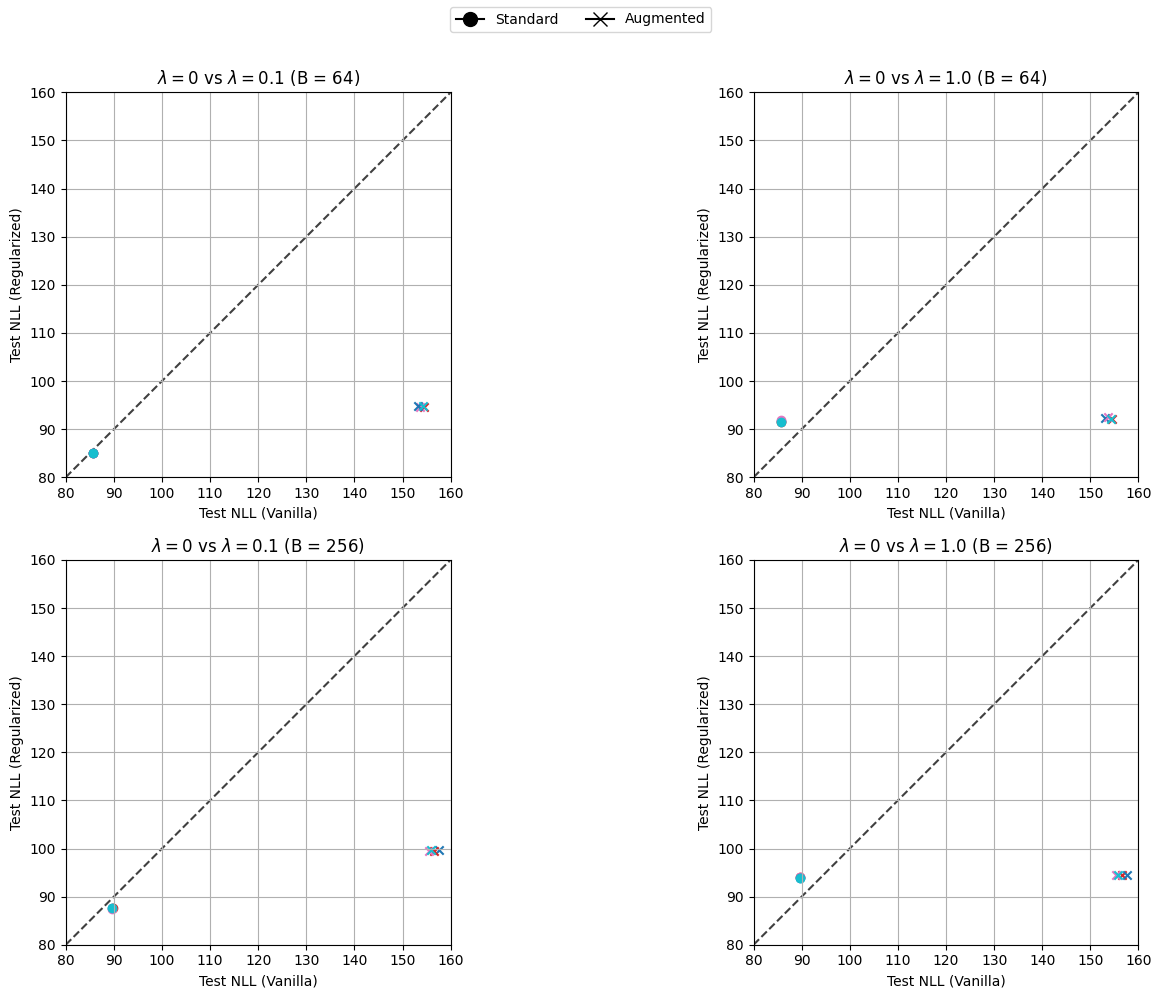

In [2]:
import os
import re
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import torch
import seaborn as sns
from data import load_data
from torch.utils.data import DataLoader
import random
from util import cross_entropy_loss_fn
# Define the result directory
result_dir = 'results_made'

# Regular expression pattern to match the directory names and extract hyperparameters
pattern = re.compile(
    r"(?P<datetime>\d{8}_\d{6})_"
    r"S(?P<seed>\d+)_"
    r"E(?P<num_epochs>\d+)_"
    r"BS(?P<batch_size>\d+)_"
    r"LR(?P<lr>[\de.-]+)_"
    r"NM(?P<n_masks>\d+)_"
    r"HL(?P<M>\d+)_"
    r"ID(?P<input_dim>\d+)_"
    r"(?P<data>[^_]+)_"
    r"BIN_"
    r"LAM(?P<lam>[\de.-]+)_"
    r"PAT(?P<patience>\d+)"
)

directories = os.listdir(result_dir)
data_dict = defaultdict(lambda: defaultdict(dict))


# Extract nll_val from directories and organize by batch_size and lam
for directory in directories:
    match = pattern.match(directory)
    if match:
        params = match.groupdict()
        batch_size = int(params['batch_size'])
        lam = float(params['lam'])
        if batch_size in [64, 256] and lam in [0, 0.1, 1.0]:
            results_path = os.path.join(result_dir, directory, 'results.json')
            if os.path.exists(results_path):
                with open(results_path, 'r') as f:
                    results = json.load(f)
                    test_nll = results.get('test_val')
                    aug_test_nll = results.get('aug_test_val')
                    nll_val = results.get('nll_val')
                    if test_nll is not None and aug_test_nll is not None:
                        seed = int(params['seed'])
                        data_dict[batch_size][lam][seed] = (test_nll, aug_test_nll, nll_val)

# Define the color map for the seeds
seeds = list(set(seed for bs in data_dict.values() for lam in bs.values() for seed in lam.keys()))
colors = plt.cm.get_cmap('tab10', len(seeds))
seed_to_color = {seed: colors(i) for i, seed in enumerate(seeds)}

# Create scatter plots in a 2x2 grid
fig1, axs1 = plt.subplots(2, 2, figsize=(15, 10))

batch_sizes = [64, 256]
lams = [0.1, 1.0]

# Determine global limits for all subplots
all_nll = []
for batch_size in batch_sizes:
    for lam in lams:
        for seed in data_dict[batch_size][lam].keys():
            test_nll, aug_test_nll, _ = data_dict[batch_size][lam][seed]
            all_nll.append(test_nll)
            all_nll.append(aug_test_nll)
global_min = 80 #min(all_nll)
global_max = 160 #max(all_nll)

for i, batch_size in enumerate(batch_sizes):
    for j, lam in enumerate(lams):
        ax = axs1[i, j]
        seeds = set(data_dict[batch_size][0].keys()) & set(data_dict[batch_size][lam].keys())
        for seed in seeds:
            test_nll_0, aug_test_nll_0, _ = data_dict[batch_size][0][seed]
            test_nll_lam, aug_test_nll_lam, _ = data_dict[batch_size][lam][seed]
            ax.scatter(test_nll_0, test_nll_lam, color=seed_to_color[seed])
            ax.scatter(aug_test_nll_0, aug_test_nll_lam, color=seed_to_color[seed], marker='x')
        ax.set_title(f'$\lambda = 0$ vs $\lambda = {lam}$ (B = {batch_size})')
        ax.set_xlabel('Test NLL (Vanilla)')
        ax.set_ylabel(f'Test NLL (Regularized)')
        
        # Add y=x dashed line
        lims = [global_min, global_max]
        ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.grid(True)

# Create a single legend for all plots
handles = [
    plt.Line2D([0], [0], marker='o', color='black', markerfacecolor='k', markersize=10, label='Standard'),
    plt.Line2D([0], [0], marker='x', color='black', markerfacecolor='k', markersize=10, label='Augmented')
]
fig1.legend(handles, ['Standard', 'Augmented'], loc='upper center', ncol=2)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


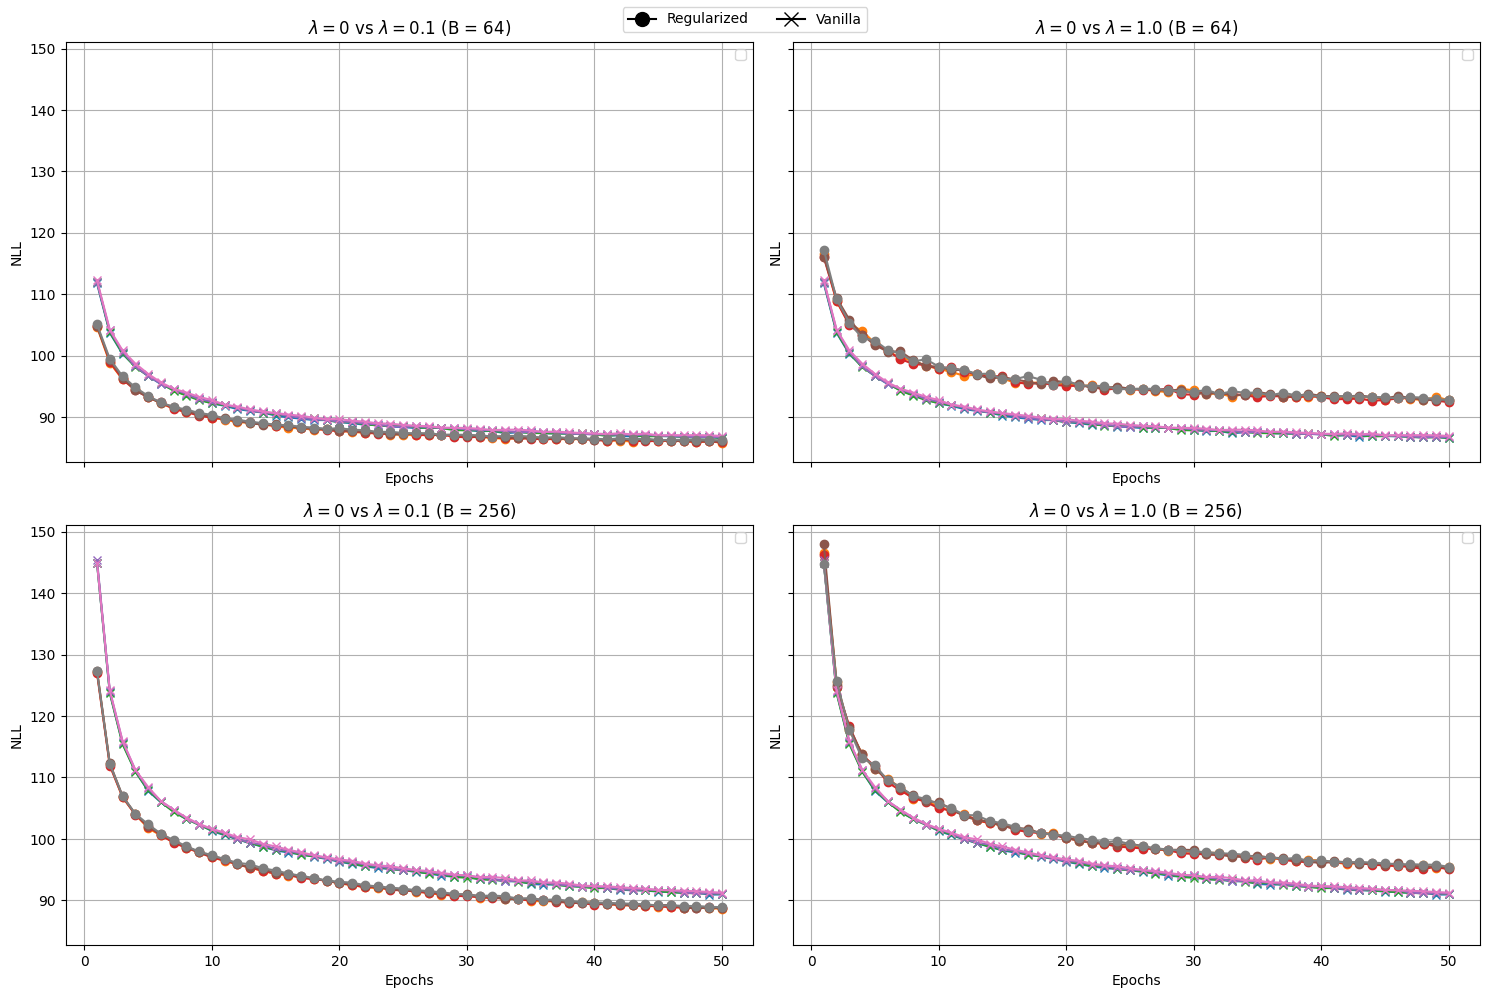

In [3]:
fig2, axs2 = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

for i, batch_size in enumerate(batch_sizes):
    for j, lam in enumerate(lams):
        ax = axs2[i, j]
        seeds = sorted(set(data_dict[batch_size][lam].keys()))
        for seed in seeds:
            _, _, nll_val_0 = data_dict[batch_size][0][seed]
            _, _, nll_val_lam = data_dict[batch_size][lam][seed]
            ax.plot(range(1, len(nll_val_0) + 1), nll_val_0, marker='x')
            ax.plot(range(1, len(nll_val_lam) + 1), nll_val_lam, marker='o')
        ax.set_title(f'$\lambda = 0$ vs $\lambda = {lam}$ (B = {batch_size})')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('NLL')
        ax.legend()
        ax.grid(True)

fig2.legend(handles, ['Regularized', 'Vanilla'], loc='upper center', ncol=2)
plt.tight_layout()
plt.show()


In [ ]:
from util import test_lls_made

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_best_vanilla = torch.load('results_made/20240718_203150_S42_E50_BS64_LR1e-03_NM1_HL8000_ID784_mnist_BIN_LAM0.0_PAT10_MOD/model_best.model', map_location=torch.device('cpu')).to(device)
model_best_regularized = torch.load('results_made/20240718_210453_S42_E50_BS64_LR1e-03_NM1_HL8000_ID784_mnist_BIN_LAM0.1_PAT10_MOD/model_best.model', map_location=torch.device('cpu')).to(device)
model_best_regularized_plus = torch.load('results_made/20240718_230620_S42_E50_BS64_LR1e-03_NM1_HL8000_ID784_mnist_BIN_LAM1.0_PAT10_MOD/model_best.model', map_location=torch.device('cpu')).to(device)
test_lls_vanilla, test_lls_vanilla_aug, test_diffs_vanilla, test_lls_regularized, test_lls_regularized_aug, test_diffs_regularized, test_lls_regularized_plus, test_lls_regularized_plus_aug, test_diffs_regularized_plus = test_lls_made(model_best_vanilla, model_best_regularized, model_best_regularized_plus, device)


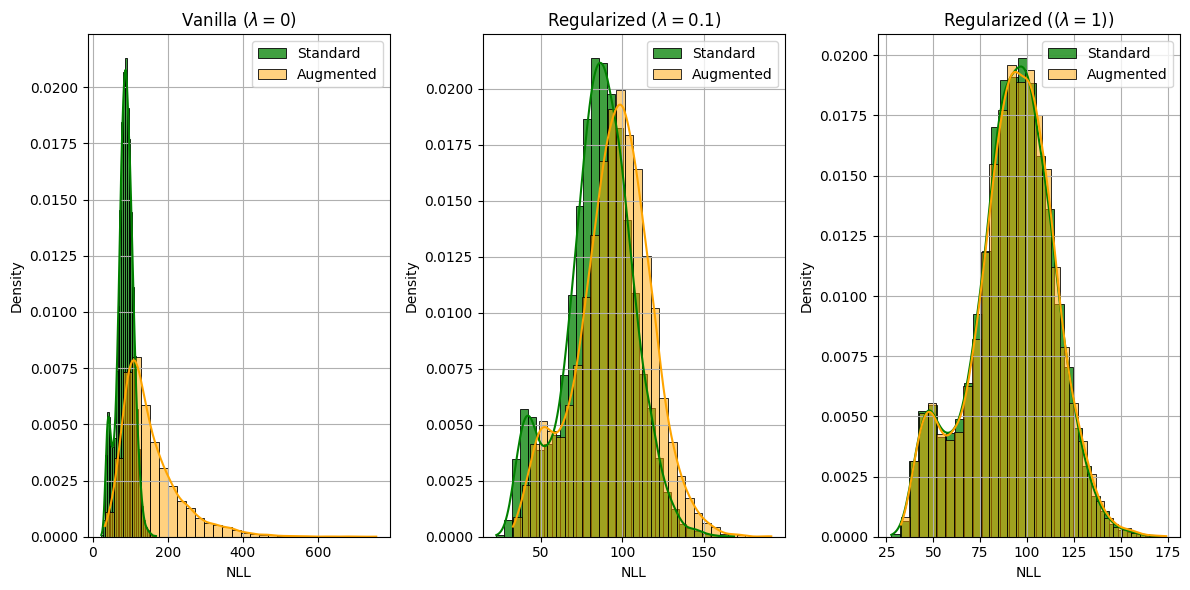

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

sns.histplot(np.array(test_lls_vanilla), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[0], label='Standard')
sns.histplot(np.array(test_lls_vanilla_aug), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[0], label='Augmented')
axs[0].set_title('Vanilla ($\lambda = 0$)')
axs[0].set_xlabel('NLL')
axs[0].set_ylabel('Density')
axs[0].legend()
axs[0].grid(True)

sns.histplot(np.array(test_lls_regularized), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[1], label='Standard')
sns.histplot(np.array(test_lls_regularized_aug), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[1], label='Augmented')
axs[1].set_title('Regularized ($\lambda = 0.1$)')
axs[1].set_xlabel('NLL')
axs[1].set_ylabel('Density')
axs[1].legend()
axs[1].grid(True)

sns.histplot(np.array(test_lls_regularized_plus), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[2], label='Standard')
sns.histplot(np.array(test_lls_regularized_plus_aug), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[2], label='Augmented')
axs[2].set_title('Regularized (($\lambda = 1$))')
axs[2].set_xlabel('NLL')
axs[2].set_ylabel('Density')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

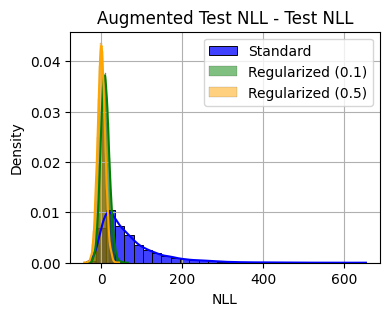

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(4, 3))
sns.histplot(-np.array(test_diffs_vanilla), bins=30, stat='density', kde=True, color='blue', alpha=0.75, ax=axs, label='Standard')
sns.histplot(-np.array(test_diffs_regularized), bins=30, stat='density', kde=True, color='green', alpha=0.5, ax=axs, label='Regularized (0.1)')
sns.histplot(-np.array(test_diffs_regularized_plus), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs, label='Regularized (0.5)')
axs.set_title('Augmented Test NLL - Test NLL')
axs.set_xlabel('NLL')
axs.set_ylabel('Density')
axs.legend()
axs.grid(True)

In [ ]:
from util import train_lls_made

train_lls_vanilla, train_lls_regularized, train_lls_regularized_plus = train_lls_made(model_best_vanilla, model_best_regularized, model_best_regularized_plus, device)

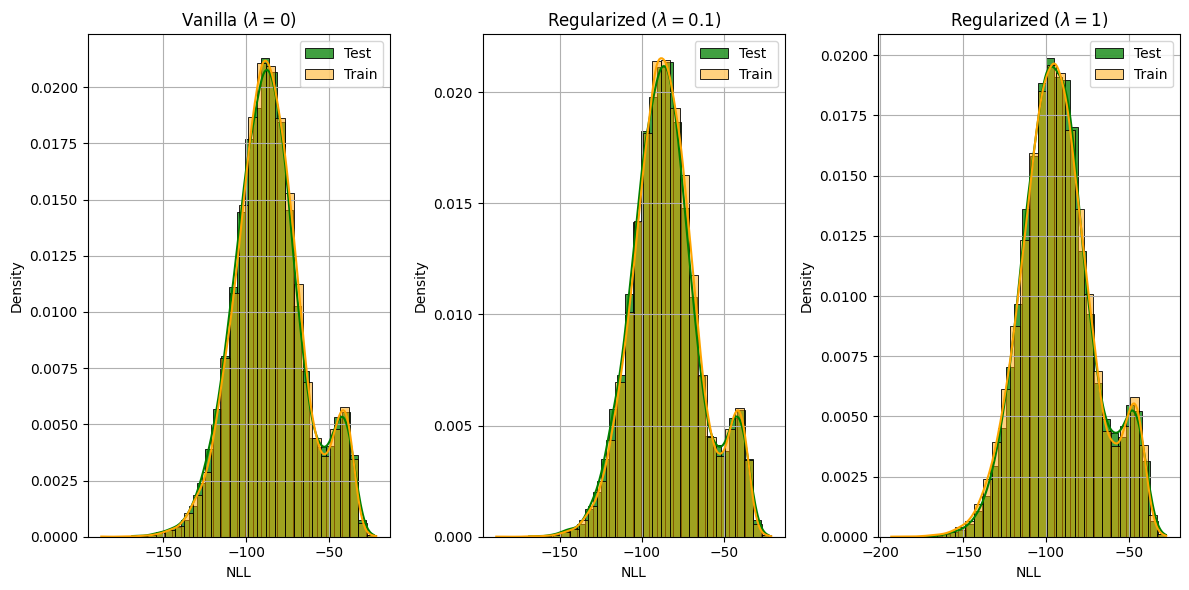

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

sns.histplot(-np.array(test_lls_vanilla), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[0], label='Test')
sns.histplot(-np.array(train_lls_vanilla), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[0], label='Train')
axs[0].set_title('Vanilla ($\lambda = 0$)')
axs[0].set_xlabel('NLL')
axs[0].set_ylabel('Density')
axs[0].legend()
axs[0].grid(True)

sns.histplot(-np.array(test_lls_regularized), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[1], label='Test')
sns.histplot(-np.array(train_lls_regularized), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[1], label='Train')
axs[1].set_title(f'Regularized ($\lambda = 0.1$)')
axs[1].set_xlabel('NLL')
axs[1].set_ylabel('Density')
axs[1].legend()
axs[1].grid(True)

sns.histplot(-np.array(test_lls_regularized_plus), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[2], label='Test')
sns.histplot(-np.array(train_lls_regularized_plus), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[2], label='Train')
axs[2].set_title('Regularized ($\lambda = 1$)')
axs[2].set_xlabel('NLL')
axs[2].set_ylabel('Density')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [9]:
### SAVE PLOT DATA
# TODO: Ensure this is saved model wise.

results_dic = {'test': {'test_lls_vanilla': test_lls_vanilla, 
                        'test_lls_regularized': test_lls_regularized, 
                        'test_lls_regularized_plus': test_lls_regularized_plus,
                        'test_lls_vanilla_aug': test_lls_vanilla_aug, 
                        'test_lls_regularized_aug': test_lls_regularized_aug, 
                        'test_lls_regularized_plus_aug': test_lls_regularized_plus_aug,
                        'test_diffs_vanilla': test_diffs_vanilla, 
                        'test_diffs_regularized': test_diffs_regularized, 
                        'test_diffs_regularized_plus': test_diffs_regularized_plus},
               'train': {'train_lls_vanilla': train_lls_vanilla, 
                         'train_lls_regularized': train_lls_regularized, 
                         'train_lls_regularized_plus': train_lls_regularized_plus}}
        
with open(result_dir + '/' + 'plots' + '/results_64.json', 'w') as json_file:
    json.dump(results_dic, json_file, indent=4)